Jaka Rizmal

Prikaz rasti števila mrtvih za gripo po celem svetu in nekaj državah.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
skiprows = [i for i in range(0, 28)] 
skiprows.extend([i for i in range(4536, 5000)])


df = pd.read_csv("../podatki/EU_gripa.csv", delimiter=",", skiprows=skiprows)
df

,COUNTRY,COUNTRY_GRP,AGE_GRP_LIST,SEX,YEAR,VALUE
0,BEL,NaN,TOTAL,FEMALE,2012,72
1,ALB,NaN,TOTAL,MALE,2008,4
2,ALB,NaN,TOTAL,FEMALE,2007,8
3,ALB,NaN,TOTAL,ALL,2007,14
4,ALB,NaN,TOTAL,MALE,2009,2
...,...,...,...,...,...,...
4502,TUR,NaN,TOTAL,FEMALE,2014,68
4503,TUR,NaN,TOTAL,ALL,2014,123
4504,TUR,NaN,TOTAL,FEMALE,2015,103
4505,TUR,NaN,TOTAL,ALL,2015,205


Vzemimo samo podatke, kjer sta spola združena - ALL. Kasneje bi lahko še primerjal spola.

In [9]:
df = df[df["SEX"]=="ALL"]
df

,COUNTRY,COUNTRY_GRP,AGE_GRP_LIST,SEX,YEAR,VALUE
3,ALB,NaN,TOTAL,ALL,2007,14
5,ALB,NaN,TOTAL,ALL,2005,29
6,ALB,NaN,TOTAL,ALL,2009,8
8,ALB,NaN,TOTAL,ALL,2006,10
9,ALB,NaN,TOTAL,ALL,2008,4
...,...,...,...,...,...,...
4493,MDA,NaN,TOTAL,ALL,2016,16
4495,NLD,NaN,TOTAL,ALL,2016,340
4500,ROU,NaN,TOTAL,ALL,2016,57
4503,TUR,NaN,TOTAL,ALL,2014,123


Sedaj združimo podatke po državah.

In [32]:
drzave = dict()
for index, row in df.iterrows():
    if row["COUNTRY"] not in drzave.keys():
        drzave[row["COUNTRY"]]=[]
    drzave[row["COUNTRY"]].append((row["YEAR"],row["VALUE"]))
    
print("Število držav v podatkih:", len(drzave.keys()))

Število držav v podatkih: 53


Sortiramo podatke, da bodo za vse države naraščali.

In [33]:
for key in drzave.keys():
    drzave[key] = sorted(drzave[key], key=lambda tup: tup[0])

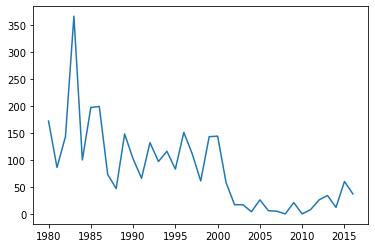

In [39]:
austria = list(zip(*drzave["AUT"]))
turkey = list(zip(*drzave["TUR"]))
plt.plot(austria[0],austria[1])

**Work in progress**